
# **Include any disclaimers about the use of AI and cite the parts of the code that AI have been used for.**

## Use of Generative AI

I used **ChatGPT (OpenAI GPT-5, cloud-based model)** to:

- Clarify assignment instructions and deliverables described in the starter notebook.
- Review and debug Python code implementation, including functions such as
  `stochastic_gradient_descent`, `train_with_minibatch`, and `train_with_minibatch_l1/l2`.
- Suggest improvements for code readability, commenting style, and figure labeling.
- Help draft written explanations for the **“# EXPLAIN HERE”** sections in the notebook.

I did **not** use ChatGPT to generate experimental results, train models, or perform analysis.
All code was executed, verified, and all hyperparameters were tuned **independently** on my local machine.

---

## Carbon Footprint Estimate

Following the course policy:

- **Model:** ChatGPT (GPT-5)
- **Hardware type:** Cloud GPU/TPU (provider: OpenAI)
- **Provider:** OpenAI
- **Region of compute:** Hamilton region
- **Time used:** ≈ 3 days × 6 hours/day ≈ **18 hours total**
- **Approximate estimate:** ≈ 350 queries × 4.32 g CO₂ ≈ **1.51 kg CO₂**

---


In [26]:
import sys
if not sys.version.startswith("3.12"):
    raise RuntimeError("This notebook requires Python 3.12")

!pip install numpy pandas matplotlib seaborn scikit-learn torch platform psutil getpass

# Hardware and user spercifications

import platform
import psutil
import getpass

# --- Setup: Imports ---
import os, seaborn, sklearn, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim

# Scikit-learn imports
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils import shuffle

#CODE HERE (optional): import any module needed from sklearn package

def print_system_info():
    print("="*60)
    print("SYSTEM INFORMATION")
    print("="*60)

    # OS and hardware
    print(f"Operating System : {platform.system()} {platform.release()}")
    print(f"Processor        : {platform.processor()}")
    print(f"CPU Cores        : {psutil.cpu_count(logical=True)}")
    print(f"RAM              : {round(psutil.virtual_memory().total / (1024**3), 2)} GB")

    # User
    print(f"PC Username      : {getpass.getuser()}")

    # Python and environment
    print(f"Python Version   : {platform.python_version()}")
    print(f"Working Dir      : {os.getcwd()}")

    # GPU (if PyTorch is installed)
    if torch.cuda.is_available():
        print(f"GPU Device       : {torch.cuda.get_device_name(0)}")
        print(f"CUDA Version     : {torch.version.cuda}")
    else:
        print("GPU Device       : None (CPU mode)")

    print("="*60)
    print()

print_system_info()

# Set a random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

SYSTEM INFORMATION
Operating System : Windows 11
Processor        : Intel64 Family 6 Model 151 Stepping 5, GenuineIntel
CPU Cores        : 12
RAM              : 15.85 GB
PC Username      : grace
Python Version   : 3.12.0
Working Dir      : C:\Users\grace\4AL3-Assignment3
GPU Device       : None (CPU mode)



'pip' is not recognized as an internal or external command,
operable program or batch file.


Here, we load, split, scale the data. Then we convert them to PyTorch Tensors.

In [27]:
# --- Data Loading and Preprocessing ---
from sklearn.datasets import load_breast_cancer

# CODE HERE: Load the dataset
data = load_breast_cancer()
X = data.data.astype(np.float32)
y = data.target.astype(np.float32).reshape(-1, 1)  # ensure (N,1)

# CODE HERE: Split the data (80% train, 20% validation). Set random_state=random_seed.
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=random_seed, stratify=y
)

# CODE HERE: Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val = scaler.transform(X_val).astype(np.float32)

# CODE HERE: Convert to PyTorch Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_val_t   = torch.tensor(y_val, dtype=torch.float32)

print(f"Training features shape: {X_train_t.shape}")
print(f"Validation features shape: {X_val_t.shape}")

Training features shape: torch.Size([455, 30])
Validation features shape: torch.Size([114, 30])


Next, we define the Neural Network (NN).

In [28]:
# --- Model Definition ---

# CODE HERE: define the asked NN here
class FeedForwardNet(nn.Module):
    """
    32 -> ReLU -> 16 -> ReLU -> 1 -> Sigmoid (probability)
    """
    def __init__(self, input_size: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

input_features = X_train_t.shape[1]
print(f"Model will accept {input_features} input features.")
print("--- 3. Model Class Defined ---")

Model will accept 30 input features.
--- 3. Model Class Defined ---


Part 1:

In [29]:
def calculate_full_loss(model, criterion, X, y):
    """Helper function to calculate loss over an entire dataset."""
    model.eval() # Set model to evaluation mode
    with torch.no_grad(): # Disable gradient calculation
        outputs = model(X)
        loss = criterion(outputs, y)
    model.train() # Set model back to train mode
    return loss.item()

def stochastic_gradient_descent(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                                max_iterations, check_every, patience, threshold):

    #CODE HERE: fill function. Use calculate_full_loss function for loss.
    n = X_train.shape[0]
    idx = np.arange(n)

    train_losses, val_losses, iterations = [], [], []
    best_model_state = None
    best_val = float("inf")
    no_improve_count = 0
    stop_iteration = max_iterations

    # Record the curve (beyond the stop point)
    for it in range(1, max_iterations + 1):
        # select 1 sample randomly
        i = np.random.randint(0, n)
        xb = X_train[i:i+1]
        yb = y_train[i:i+1]

        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        if it % check_every == 0 or it == 1 or it == max_iterations:
            tr = calculate_full_loss(model, criterion, X_train, y_train)
            vl = calculate_full_loss(model, criterion, X_val, y_val)
            train_losses.append(tr)
            val_losses.append(vl)
            iterations.append(it)

            # Monitor the best model (based on the minimum validation loss
            if vl + 1e-12 < best_val:
                best_val = vl
                best_model_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
                no_improve_count = 0
            else:
                # Whether the early stop standard of "changes below the threshold" has been reached
                if len(val_losses) >= 2 and abs(val_losses[-2] - val_losses[-1]) < threshold:
                    no_improve_count += 1
                else:
                    no_improve_count = 0

                if no_improve_count >= patience:
                    stop_iteration = it
                    # Keep running to 120% of max_iterations/or at least draw a few more dots for "visualization after plateau"
                    extra = max(check_every * patience, 0)
                    target = min(max_iterations, it + extra)
                    while iterations[-1] < target:
                        tr = calculate_full_loss(model, criterion, X_train, y_train)
                        vl = calculate_full_loss(model, criterion, X_val, y_val)
                        train_losses.append(tr)
                        val_losses.append(vl)
                        iterations.append(iterations[-1] + check_every)
                    break

    # Restore the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return train_losses, val_losses, iterations, stop_iteration, best_model_state

Training and plot:

Plotting Part 1 results...


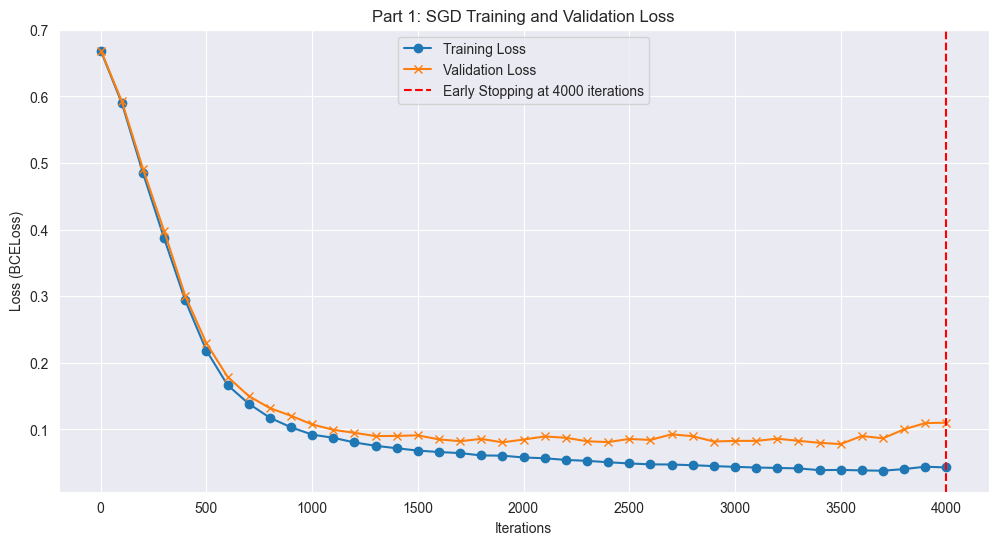


Accuracy of Early-Stopped Model on Validation Set: 96.49%


In [30]:
# --- Hyperparameters for Part 1 ---
LEARNING_RATE = 1e-2
MAX_ITERATIONS = 4000
CHECK_EVERY = 100
PATIENCE = 5
THRESHOLD = 1e-4

# --- Model Initialization ---

#CODE HERE
model_sgd = FeedForwardNet(input_features)
criterion = nn.BCELoss()
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=LEARNING_RATE)

# --- Run Training ---

#CODE HERE
train_losses_sgd, val_losses_sgd, iterations_sgd, stop_iter, _best = stochastic_gradient_descent(
    model_sgd, criterion, optimizer_sgd,
    X_train_t, y_train_t, X_val_t, y_val_t,
    MAX_ITERATIONS, CHECK_EVERY, PATIENCE, THRESHOLD
)

# --- Plotting Results ---
print("Plotting Part 1 results...")
plt.figure(figsize=(12, 6))
plt.plot(iterations_sgd, train_losses_sgd, label='Training Loss', marker='o')
plt.plot(iterations_sgd, val_losses_sgd, label='Validation Loss', marker='x')
plt.axvline(x=stop_iter, color='red', linestyle='--',
            label=f'Early Stopping at {stop_iter} iterations')
plt.title('Part 1: SGD Training and Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss (BCELoss)')
plt.legend()
plt.grid(True)
plt.show()

# --- Final Accuracy ---

#CODE HERE
with torch.no_grad():

    #CODE HERE
    y_val_prob = model_sgd(X_val_t)
    y_val_pred = (y_val_prob > 0.5).int().numpy()
    y_val_true = y_val_t.numpy().astype(int)
    accuracy = accuracy_score(y_val_true, y_val_pred)
    
    print(f"\nAccuracy of Early-Stopped Model on Validation Set: {accuracy * 100:.2f}%")


Part 2:

In [31]:
def train_with_minibatch(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                         num_iterations, batch_size, check_every):

    #CODE HERE: fill function
    n_samples = X_train.shape[0]
    train_losses, val_losses, iterations = [], [], []

    Xs = X_train.clone()
    ys = y_train.clone()
    cur = 0

    for i in range(1, num_iterations + 1):
        if cur + batch_size > n_samples:
            X_np, y_np = shuffle(Xs.numpy(), ys.numpy(), random_state=random_seed + i)
            Xs = torch.tensor(X_np, dtype=torch.float32)
            ys = torch.tensor(y_np, dtype=torch.float32)
            cur = 0

        xb = Xs[cur:cur+batch_size]
        yb = ys[cur:cur+batch_size]
        cur += batch_size

        model.train()
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        if i % check_every == 0 or i == 1 or i == num_iterations:
            tr = calculate_full_loss(model, criterion, X_train, y_train)
            vl = calculate_full_loss(model, criterion, X_val, y_val)
            train_losses.append(tr)
            val_losses.append(vl)
            iterations.append(i)
            
    return train_losses, val_losses, iterations, model # Return the final model


Training and plot:

Plotting Part 2 comparison...


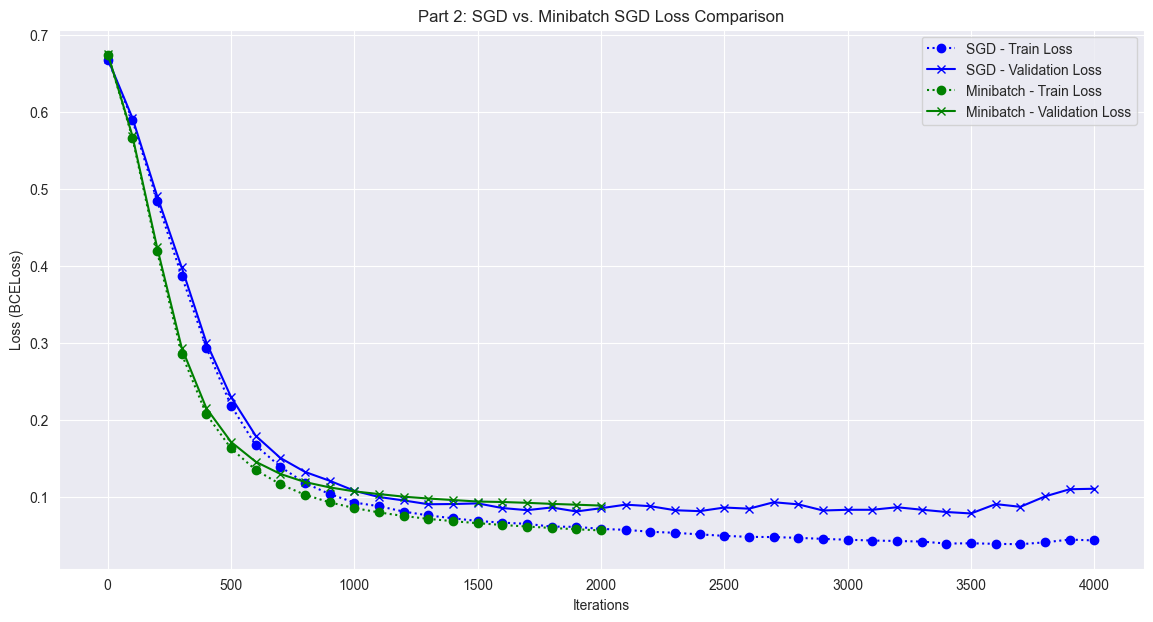

In [32]:
# --- Hyperparameters for Part 2 ---
LEARNING_RATE_MB = 1e-2
NUM_ITERATIONS_MB = 2000
BATCH_SIZE = 32
CHECK_EVERY_MB = 100

# --- Model Initialization ---

#CODE HERE
model_mb = FeedForwardNet(input_features)
optimizer_mb = optim.SGD(model_mb.parameters(), lr=LEARNING_RATE_MB)

# --- Run Minibatch Training ---

#CODE HERE
train_losses_mb, val_losses_mb, iterations_mb, model_mb = train_with_minibatch(
    model_mb, criterion, optimizer_mb,
    X_train_t, y_train_t, X_val_t, y_val_t,
    NUM_ITERATIONS_MB, BATCH_SIZE, CHECK_EVERY_MB
)

# --- Plotting Comparison ---
print("Plotting Part 2 comparison...")
plt.figure(figsize=(14, 7))

# SGD (Part 1)
plt.plot(iterations_sgd, train_losses_sgd, label='SGD - Train Loss', linestyle=':', color='blue', marker='o')
plt.plot(iterations_sgd, val_losses_sgd, label='SGD - Validation Loss', linestyle='-', color='blue', marker='x')

# Minibatch (Part 2)
plt.plot(iterations_mb, train_losses_mb, label='Minibatch - Train Loss', linestyle=':', color='green', marker='o')
plt.plot(iterations_mb, val_losses_mb, label='Minibatch - Validation Loss', linestyle='-', color='green', marker='x')

plt.title('Part 2: SGD vs. Minibatch SGD Loss Comparison')
plt.xlabel('Iterations')
plt.ylabel('Loss (BCELoss)')
plt.legend()
plt.grid(True)
plt.show()

Performance evaluation:

In [33]:
# --- Performance Metrics Comparison ---

def get_metrics(model, X_val, y_val):
    """Helper function to get accuracy, precision, and recall."""
    model.eval()
    with torch.no_grad():
        y_pred_prob = model(X_val)
        y_pred = (y_pred_prob > 0.5).int().numpy() # Convert to numpy
        y_true = y_val.numpy()

        acc = accuracy_score(y_true, y_pred)
        pre = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
    return acc, pre, rec

# Get metrics for Part 1 (Early-Stopped SGD Model)

#CODE HERE: USING get_metrics function
acc_sgd, pre_sgd, rec_sgd = get_metrics(model_sgd, X_val_t, y_val_t)

# Get metrics for Part 2 (Final Minibatch Model)

#CODE HERE: USING get_metrics function
acc_mb, pre_mb, rec_mb = get_metrics(model_mb, X_val_t, y_val_t)

# --- Show Results in a Table ---
results = {
    'Metric': ['Accuracy', 'Precision', 'Recall'],
    'Part 1: Early-Stopped SGD': [f"{acc_sgd:.4f}", f"{pre_sgd:.4f}", f"{rec_sgd:.4f}"],
    'Part 2: Minibatch SGD': [f"{acc_mb:.4f}", f"{pre_mb:.4f}", f"{rec_mb:.4f}"]
}

results_df = pd.DataFrame(results)
print("\n--- Final Performance Metrics on Validation Set ---")

from IPython.display import display
display(results_df)



--- Final Performance Metrics on Validation Set ---


,Metric,Part 1: Early-Stopped SGD,Part 2: Minibatch SGD
0,Accuracy,0.9649,0.9737
1,Precision,0.9857,0.9859
2,Recall,0.9583,0.9722


# EXPLAIN HERE: Based on your experiments, answer the following questions:

1) How does early stopping affect the training and validation loss curves compared to training for all 5000 iterations?

    Early stopping reduces overfitting, shortens training time, and ensures the model selected is the one with the lowest validation loss rather than the one trained the longest.
2) How does minibatch SGD affect the smoothness of loss curves compared to true SGD with batch_size=1?

    Mini-batch SGD stabilizes training by reducing gradient variance, produces smoother loss curves, and can reach comparable or better accuracy with fewer oscillations.


***Part 3***

In [47]:
class FeedForwardNetWithDropout(nn.Module):
    """
    TODO: Complete this neural network class to include dropout layers.

    The dropout_rate parameter should control the dropout probability.
    When dropout_rate=0.0, no dropout is applied.
    """
    def __init__(self, input_size, dropout_rate=0.0):
        super(FeedForwardNetWithDropout, self).__init__()

        #CODE HERE: Define the NN architecture
        #super().__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.out = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p=dropout_rate)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """
        TODO: Implement the forward pass.

        Return the final output.
        """
        x = self.relu(self.fc1(x))
        x = self.drop(x)
        x = self.relu(self.fc2(x))
        x = self.drop(x)
        out = self.sigmoid(self.out(x))

        return out




In [48]:
def calculate_accuracy(model, X, y):
    """
    TODO: Implement accuracy calculation.


    """
    # CODE HERE: Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        # CODE HERE: Get model outputs
        #outputs = None  # REPLACE WITH YOUR CODE
        outputs = model(X)
        #predictions = None  # REPLACE WITH YOUR CODE
        preds = (outputs > 0.5).int()
        #accuracy = None  # REPLACE WITH YOUR CODE
        accuracy = (preds.eq(y.int())).float().mean().item()

    return accuracy


In [49]:
def train_with_dropout(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                                 num_iterations, batch_size, check_every):
    """
    TODO: Complete this training function to support dropout.

    """
    # CODE HERE: Use need to fill like using miniSGD in part 2
    n_samples = X_train.shape[0]
    train_losses, val_losses, train_accs, val_accs, iterations = [], [], [], [], []

    Xs = X_train.clone()
    ys = y_train.clone()
    cur = 0

    for i in range(1, num_iterations + 1):
        if cur + batch_size > n_samples:
            X_np, y_np = shuffle(Xs.numpy(), ys.numpy(), random_state=random_seed + i)
            Xs = torch.tensor(X_np, dtype=torch.float32)
            ys = torch.tensor(y_np, dtype=torch.float32)
            cur = 0

        xb = Xs[cur:cur+batch_size]
        yb = ys[cur:cur+batch_size]
        cur += batch_size

        model.train()
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        if i % check_every == 0 or i == 1 or i == num_iterations:
            tr_loss = calculate_full_loss(model, criterion, X_train, y_train)
            vl_loss = calculate_full_loss(model, criterion, X_val, y_val)
            tr_acc  = calculate_accuracy(model, X_train, y_train)
            vl_acc  = calculate_accuracy(model, X_val, y_val)

            train_losses.append(tr_loss)
            val_losses.append(vl_loss)
            train_accs.append(tr_acc)
            val_accs.append(vl_acc)
            iterations.append(i)
            
    return train_losses, val_losses, train_accs, val_accs, iterations

In [50]:
DROPOUT_RATES = [0.1, 0.3, 0.5]
LEARNING_RATE_DROPOUT = 1e-2
NUM_ITERATIONS_DROPOUT = 2000
BATCH_SIZE_DROPOUT = 32
CHECK_EVERY_DROPOUT = 100

dropout_results = {}
train_with_minibatch_dropout = train_with_dropout
for dropout_rate in DROPOUT_RATES:
    print(f"\n--- Training with Dropout Rate = {dropout_rate} ---")

    # CODE HERE: Initialize model with current dropout_rate
    #model = None  # REPLACE WITH YOUR CODE
    model = FeedForwardNetWithDropout(input_features, dropout_rate=dropout_rate)  # REPLACE WITH YOUR CODE
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE_DROPOUT)

    # Train the model
    train_losses, val_losses, train_accs, val_accs, iterations = train_with_minibatch_dropout(
        model, criterion, optimizer,
        X_train_t, y_train_t, X_val_t, y_val_t,
        NUM_ITERATIONS_DROPOUT, BATCH_SIZE_DROPOUT, CHECK_EVERY_DROPOUT
    )

    # Store results for later comparison
    dropout_results[dropout_rate] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'iterations': iterations,
        'model': model
    }

    print(f"Final Training Accuracy: {train_accs[-1]*100:.2f}%")
    print(f"Final Validation Accuracy: {val_accs[-1]*100:.2f}%")



--- Training with Dropout Rate = 0.1 ---
Final Training Accuracy: 98.68%
Final Validation Accuracy: 97.37%

--- Training with Dropout Rate = 0.3 ---
Final Training Accuracy: 98.90%
Final Validation Accuracy: 96.49%

--- Training with Dropout Rate = 0.5 ---
Final Training Accuracy: 98.68%
Final Validation Accuracy: 97.37%


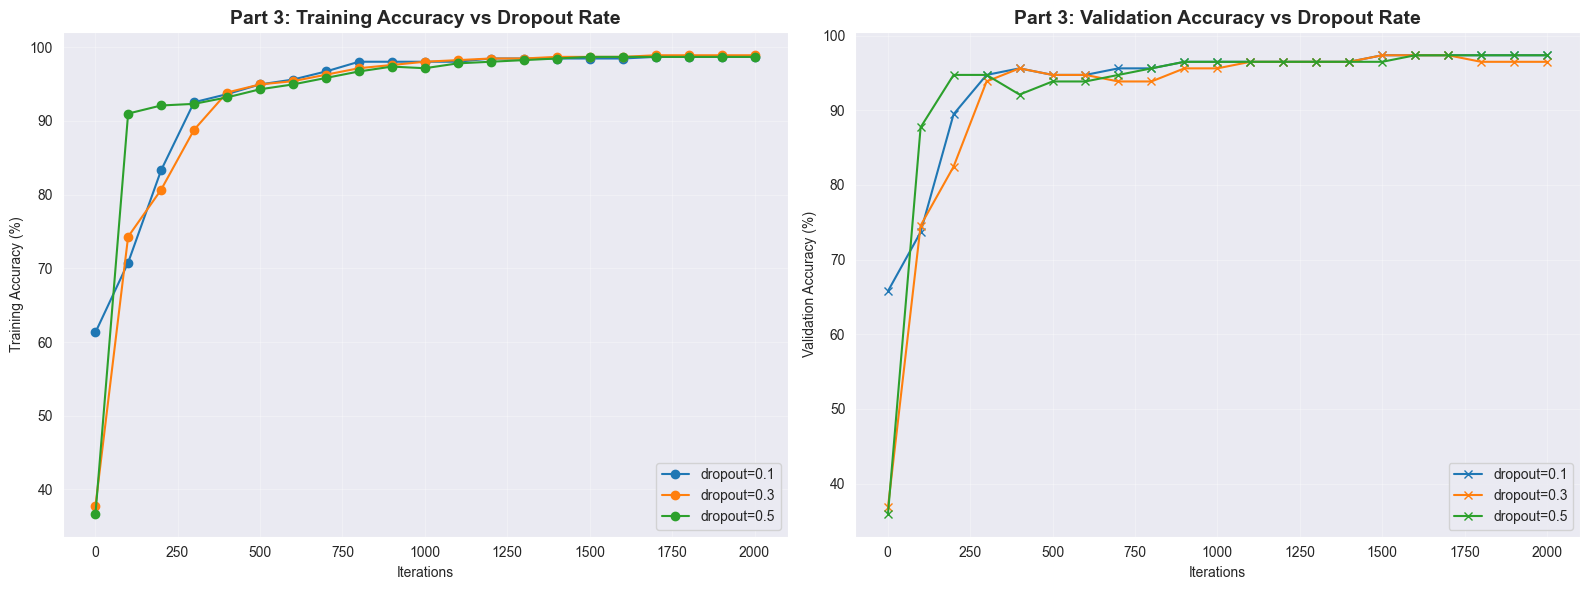

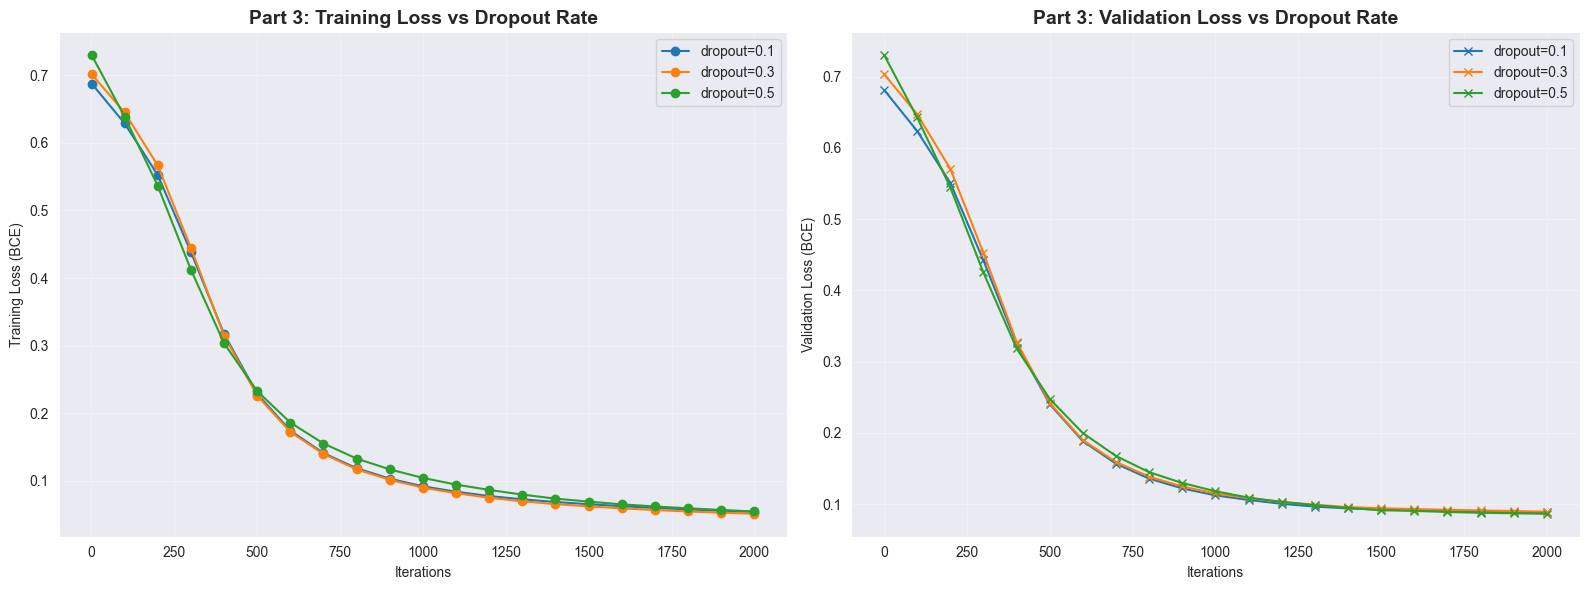

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot accuracies/validations vs dropouts
# CODE HERE: inject points in plots
for dr, res in dropout_results.items():
    axes[0].plot(res['iterations'], np.array(res['train_accs'])*100, marker='o', label=f'dropout={dr}')

axes[0].set_title('Part 3: Training Accuracy vs Dropout Rate', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Training Accuracy (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)


# CODE HERE: inject points in plots
for dr, res in dropout_results.items():
    axes[1].plot(res['iterations'], np.array(res['val_accs'])*100, marker='x', label=f'dropout={dr}')

axes[1].set_title('Part 3: Validation Accuracy vs Dropout Rate', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Validation Accuracy (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for dr, res in dropout_results.items():
    axes[0].plot(res['iterations'], res['train_losses'], marker='o', label=f'dropout={dr}')

axes[0].set_title('Part 3: Training Loss vs Dropout Rate', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Training Loss (BCE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for dr, res in dropout_results.items():
    axes[1].plot(res['iterations'], res['val_losses'], marker='x', label=f'dropout={dr}')

axes[1].set_title('Part 3: Validation Loss vs Dropout Rate', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Validation Loss (BCE)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [52]:
# CODE HERE: Create a summary dataframe with the following columns:

dropout_summary = {
    'Dropout Rate': [],
    'Final Train Acc (%)': [],
    'Final Val Acc (%)': [],
    'Final Train Loss': [],
    'Final Val Loss': []
}

# CODE HERE: Fill the summary dictionary by looping through DROPOUT_RATES
for dr, res in dropout_results.items():
    dropout_summary['Dropout Rate'].append(dr)
    dropout_summary['Final Train Acc (%)'].append(round(res['train_accs'][-1]*100, 2))
    dropout_summary['Final Val Acc (%)'].append(round(res['val_accs'][-1]*100, 2))
    dropout_summary['Final Train Loss'].append(round(res['train_losses'][-1], 4))
    dropout_summary['Final Val Loss'].append(round(res['val_losses'][-1], 4))

dropout_df = pd.DataFrame(dropout_summary)
display(dropout_df)



,Dropout Rate,Final Train Acc (%),Final Val Acc (%),Final Train Loss,Final Val Loss
0,0.1,98.68,97.37,0.0540,0.0886
1,0.3,98.90,96.49,0.0511,0.0895
2,0.5,98.68,97.37,0.0545,0.0865


# EXPLAIN HERE: Based on your results, answer the following questions:


1. Which dropout rate shows the best generalization (smallest gap between
   training and validation accuracy)?

    Dropout rates of 0.1 and 0.5 demonstrate the best generalization capability.

2. Which dropout rate would you recommend for this dataset and why?

    Dropout = 0.5 offers the best trade-off between preventing overfitting and maintaining high model accuracy.

3. What are the trade-offs between low dropout (0.1) and high dropout (0.5)?

    Low dropout is suitable when the dataset is large or the model is relatively small, while high dropout is better for small datasets or when overfitting is a concern — though at the cost of slower learning.

***Part 4***

In [67]:
def train_with_minibatch_l2(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                            num_iterations, batch_size, check_every):
    """
    #TODO: Implement training with L2 regularization.

    """
    n_samples = X_train.shape[0]
    train_losses, val_losses, iterations = [], [], []

    X_train_shuffled = X_train.clone()
    y_train_shuffled = y_train.clone()
    current_idx = 0

    for i in range(num_iterations + 1):
        if current_idx + batch_size > n_samples:
            X_train_np, y_train_np = shuffle(X_train_shuffled.numpy(), y_train_shuffled.numpy(),
                                            random_state=random_seed + i)
            X_train_shuffled = torch.tensor(X_train_np, dtype=torch.float32)
            y_train_shuffled = torch.tensor(y_train_np, dtype=torch.float32)
            current_idx = 0

        X_batch = X_train_shuffled[current_idx : current_idx + batch_size]
        y_batch = y_train_shuffled[current_idx : current_idx + batch_size]
        current_idx += batch_size

        # CODE HERE: Complete the training
        model.train()
        optimizer.zero_grad()
        out = model(X_batch)
        loss = criterion(out, y_batch)  # L2 由 weight_decay 注入
        loss.backward()
        optimizer.step()

        if i % check_every == 0:
            # CODE HERE: Calculate and store training and validation losses
            tr = calculate_full_loss(model, criterion, X_train, y_train)
            vl = calculate_full_loss(model, criterion, X_val, y_val)
            train_losses.append(tr)
            val_losses.append(vl)
            iterations.append(i)
            pass

    return train_losses, val_losses, iterations


In [68]:
def train_with_minibatch_l1(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                            num_iterations, batch_size, check_every, lambda_l1):
    """
    TODO: Implement training with manual L1 regularization.
    """
    n_samples = X_train.shape[0]
    train_losses, val_losses, iterations = [], [], []

    X_train_shuffled = X_train.clone()
    y_train_shuffled = y_train.clone()
    current_idx = 0

    for i in range(num_iterations + 1):
        if current_idx + batch_size > n_samples:
            X_train_np, y_train_np = shuffle(X_train_shuffled.numpy(), y_train_shuffled.numpy(),
                                            random_state=random_seed + i)
            X_train_shuffled = torch.tensor(X_train_np, dtype=torch.float32)
            y_train_shuffled = torch.tensor(y_train_np, dtype=torch.float32)
            current_idx = 0

        X_batch = X_train_shuffled[current_idx : current_idx + batch_size]
        y_batch = y_train_shuffled[current_idx : current_idx + batch_size]
        current_idx += batch_size

        model.train()
        optimizer.zero_grad()

        # CODE HERE: Calculate outputs and BCE loss
        #outputs = None  # REPLACE WITH YOUR CODE
        outputs = model(X_batch)
        #loss = None  # REPLACE WITH YOUR CODE
        loss = criterion(outputs, y_batch)

        # CODE HERE: Calculate L1 penalty

        l1_penalty = 0
        for p in model.parameters():
            l1_penalty = l1_penalty + p.abs().sum()

        # CODE HERE: Calculate total loss
        #total_loss = None  # REPLACE WITH YOUR CODE
        total_loss = loss + lambda_l1 * l1_penalty  # REPLACE WITH YOUR CODE

        # TODO: Backpropagate and update weights using total_loss
        total_loss.backward()
        optimizer.step()

        if i % check_every == 0:
            # CODE HERE: Calculate losses
            tr = calculate_full_loss(model, criterion, X_train, y_train)
            vl = calculate_full_loss(model, criterion, X_val, y_val)
            train_losses.append(tr)
            val_losses.append(vl)
            iterations.append(i)
            pass

    return train_losses, val_losses, iterations

In [69]:
LAMBDA_L2_VALUES = [0.0, 1e-4, 1e-3]
LEARNING_RATE_L2 = 1e-2
NUM_ITERATIONS_L2 = 2000
BATCH_SIZE_L2 = 32
CHECK_EVERY_L2 = 100

l2_results = {}

for lambda_l2 in LAMBDA_L2_VALUES:
    print(f"\n--- Training with L2 λ = {lambda_l2} ---")

    # CODE HERE: Initialize & train the model (use original FeedForwardNet, no dropout)
    model = FeedForwardNet(input_features)
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE_L2, weight_decay=lambda_l2)

    train_losses, val_losses, iterations = train_with_minibatch_l2(
        model, criterion, optimizer,
        X_train_t, y_train_t, X_val_t, y_val_t,
        NUM_ITERATIONS_L2, BATCH_SIZE_L2, CHECK_EVERY_L2
    )

    # CODE HERE: Calculate final validation accuracy
    final_accuracy, _, _ = get_metrics(model, X_val_t, y_val_t)

    # Store results
    l2_results[lambda_l2] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'iterations': iterations,
        'final_accuracy': final_accuracy,
        'model': model
    }

    print(f"Final Validation Accuracy: {final_accuracy*100:.2f}%")


--- Training with L2 λ = 0.0 ---
Final Validation Accuracy: 95.61%

--- Training with L2 λ = 0.0001 ---
Final Validation Accuracy: 96.49%

--- Training with L2 λ = 0.001 ---
Final Validation Accuracy: 96.49%


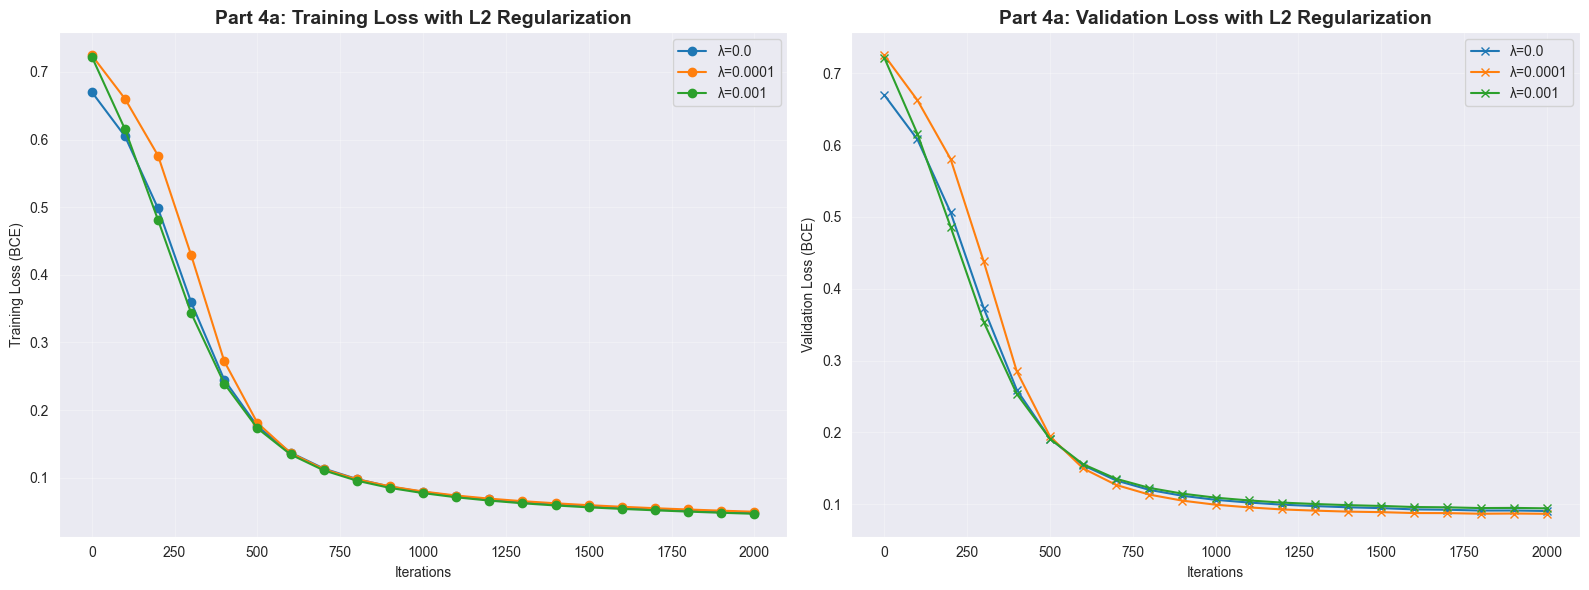

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# TODO: Plot training/validation loss for all L2 values
# CODE HERE: Inject points to plots
for lam, res in l2_results.items():
    axes[0].plot(res['iterations'], res['train_losses'], marker='o', label=f'λ={lam}')

axes[0].set_title('Part 4a: Training Loss with L2 Regularization', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Training Loss (BCE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# CODE HERE: Inject points to plots
for lam, res in l2_results.items():
    axes[1].plot(res['iterations'], res['val_losses'], marker='x', label=f'λ={lam}')

axes[1].set_title('Part 4a: Validation Loss with L2 Regularization', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Validation Loss (BCE)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [71]:
LAMBDA_L1 = 1e-4

# CODE HERE : Initialize model, criterion, and optimizer for L1 experiment
model_l1 = FeedForwardNet(input_features)
criterion_l1 = nn.BCELoss()
optimizer_l1 = optim.SGD(model_l1.parameters(), lr=LEARNING_RATE_L2)

# Train with L1
train_losses_l1, val_losses_l1, iterations_l1 = train_with_minibatch_l1(
    model_l1, criterion_l1, optimizer_l1,
    X_train_t, y_train_t, X_val_t, y_val_t,
    NUM_ITERATIONS_L2, BATCH_SIZE_L2, CHECK_EVERY_L2, LAMBDA_L1
)

# CODE HERE: Calculate final validation accuracy for L1 model
final_accuracy_l1, _, _ = get_metrics(model_l1, X_val_t, y_val_t)

print(f"Final Validation Accuracy (L1): {final_accuracy_l1*100:.2f}%")

Final Validation Accuracy (L1): 95.61%


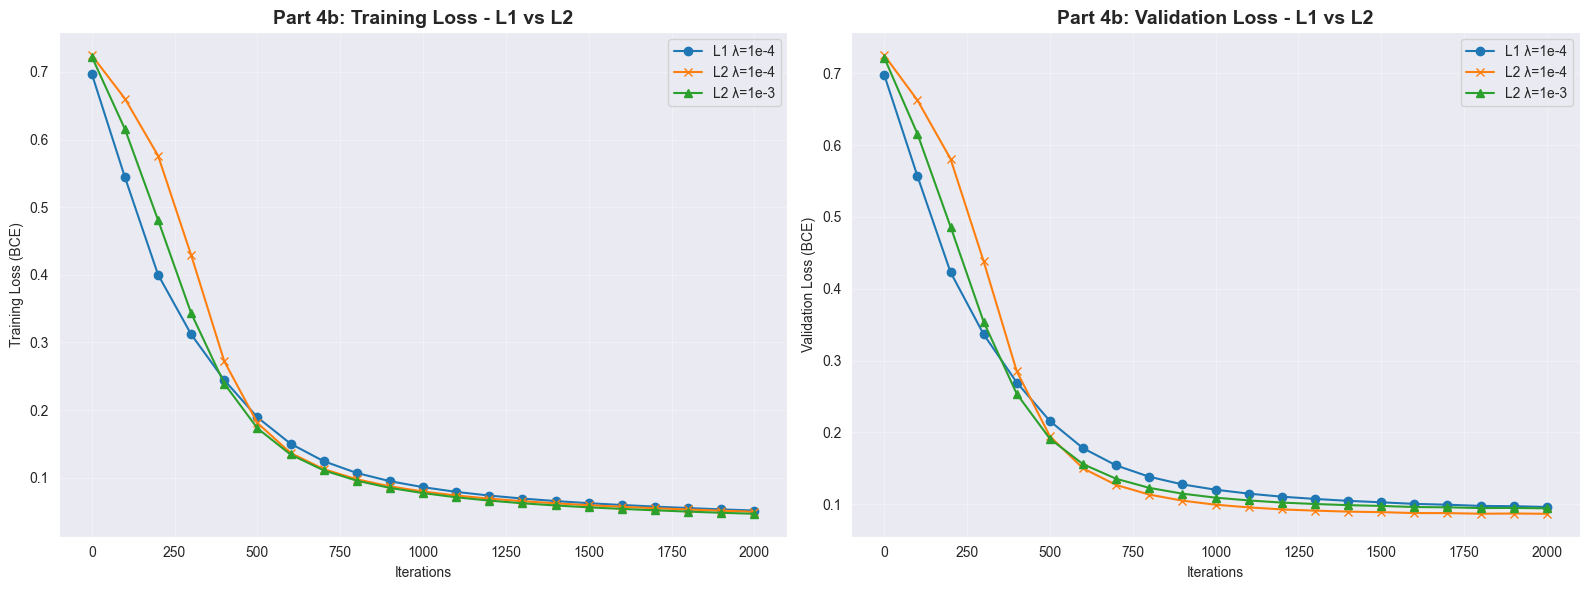

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# CODE HERE: inject points to plots
axes[0].plot(iterations_l1, train_losses_l1, marker='o', label='L1 λ=1e-4')
if 1e-4 in l2_results:
    axes[0].plot(l2_results[1e-4]['iterations'], l2_results[1e-4]['train_losses'], marker='x', label='L2 λ=1e-4')
if 1e-3 in l2_results:
    axes[0].plot(l2_results[1e-3]['iterations'], l2_results[1e-3]['train_losses'], marker='^', label='L2 λ=1e-3')

axes[0].set_title('Part 4b: Training Loss - L1 vs L2', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Training Loss (BCE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# CODE HERE: inject points to plots
axes[1].plot(iterations_l1, val_losses_l1, marker='o', label='L1 λ=1e-4')
if 1e-4 in l2_results:
    axes[1].plot(l2_results[1e-4]['iterations'], l2_results[1e-4]['val_losses'], marker='x', label='L2 λ=1e-4')
if 1e-3 in l2_results:
    axes[1].plot(l2_results[1e-3]['iterations'], l2_results[1e-3]['val_losses'], marker='^', label='L2 λ=1e-3')

axes[1].set_title('Part 4b: Validation Loss - L1 vs L2', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Validation Loss (BCE)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [73]:

# TODO: Create a summary dataframe with columns:
# Fill rows for: No regularization, L2 (1e-4), L2 (1e-3), L1 (1e-4)
# CODE HERE

reg_summary = {
    'Regularization': [],
    'Final Val Acc (%)': [],
    'Final Train Loss': [],
    'Final Val Loss': [],
    'Sparsity (%)': []
}

# TODO: Fill the summary dictionary
# CODE HERE
def count_sparsity(model, eps=1e-6):
    total, near_zero = 0, 0
    with torch.no_grad():
        for p in model.parameters():
            if p.ndim == 0:  # skip scalars
                continue
            total += p.numel()
            near_zero += (p.abs() < eps).sum().item()
    return 100.0 * near_zero / max(total, 1)

# The baseline uses the model_mb trained in Part 2
reg_summary['Regularization'].append('None')
acc0, _, _ = get_metrics(model_mb, X_val_t, y_val_t)
reg_summary['Final Val Acc (%)'].append(round(acc0*100, 2))
reg_summary['Final Train Loss'].append(round(calculate_full_loss(model_mb, criterion, X_train_t, y_train_t), 4))
reg_summary['Final Val Loss'].append(round(calculate_full_loss(model_mb, criterion, X_val_t, y_val_t), 4))
reg_summary['Sparsity (%)'].append(round(count_sparsity(model_mb), 2))

# L2 (1e-4)
if 1e-4 in l2_results:
    m = l2_results[1e-4]['model']
    reg_summary['Regularization'].append('L2 (1e-4)')
    reg_summary['Final Val Acc (%)'].append(round(l2_results[1e-4]['final_accuracy']*100, 2))
    reg_summary['Final Train Loss'].append(round(l2_results[1e-4]['train_losses'][-1], 4))
    reg_summary['Final Val Loss'].append(round(l2_results[1e-4]['val_losses'][-1], 4))
    reg_summary['Sparsity (%)'].append(round(count_sparsity(m), 2))

# L2 (1e-3)
if 1e-3 in l2_results:
    m = l2_results[1e-3]['model']
    reg_summary['Regularization'].append('L2 (1e-3)')
    reg_summary['Final Val Acc (%)'].append(round(l2_results[1e-3]['final_accuracy']*100, 2))
    reg_summary['Final Train Loss'].append(round(l2_results[1e-3]['train_losses'][-1], 4))
    reg_summary['Final Val Loss'].append(round(l2_results[1e-3]['val_losses'][-1], 4))
    reg_summary['Sparsity (%)'].append(round(count_sparsity(m), 2))

# L1 (1e-4)
reg_summary['Regularization'].append('L1 (1e-4)')
reg_summary['Final Val Acc (%)'].append(round(final_accuracy_l1*100, 2))
reg_summary['Final Train Loss'].append(round(train_losses_l1[-1], 4))
reg_summary['Final Val Loss'].append(round(val_losses_l1[-1], 4))
reg_summary['Sparsity (%)'].append(round(count_sparsity(model_l1), 2))

reg_df = pd.DataFrame(reg_summary)
display(reg_df)


,Regularization,Final Val Acc (%),Final Train Loss,Final Val Loss,Sparsity (%)
0,None,97.37,0.0560,0.0883,0.00
1,L2 (1e-4),96.49,0.0498,0.0866,0.00
2,L2 (1e-3),96.49,0.0467,0.0942,0.00
3,L1 (1e-4),95.61,0.0516,0.0961,0.13



# EXPLAIN HERE: Based on your experiments, answer the following questions:


1. What happens when you increase L2 strength from λ=1e-4 to λ=1e-3?

    Increasing L2 from 1e-4 → 1e-3 does not help generalization here; it slightly hurts (higher val loss, no accuracy gain).

2. Which regularization method (L1/L2 or no regulation) achieves better generalization for this breast cancer dataset?

    No regularization yields the best accuracy; L2 (1e-4) is a reasonable alternative if slight regularization is desired.
   